In [37]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
autoreload 2

In [39]:
# Import Libraries

import math
import pandas as pd
import os
import torch.optim as optim
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
import numpy as np
import torch
import torch.nn as nn

import sys
sys.path.append('../')
sys.path.append('../BayesCNN/')
from utils import DEVICE
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore')

Var = lambda x, dtype=torch.FloatTensor: Variable(
    torch.from_numpy(x).type(dtype)).to(DEVICE)

In [40]:
#### CUDA NOT YET IMPLEMENTED - DISABLE IN BayesBackpropagation.py ###

NB_STEPS = 10000
print('running for {0} steps'.format(NB_STEPS))

# Import data from file
df = pd.read_csv(os.getcwd() + '/Pytorch/agaricus-lepiota.data', sep=',', header=None,
             error_bad_lines=False, warn_bad_lines=True, low_memory=False)

# Set pandas to output all of the columns in output
df.columns = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
         'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
         'stalk-surf-above-ring','stalk-surf-below-ring','stalk-color-above-ring','stalk-color-below-ring',
         'veil-type','veil-color','ring-number','ring-type','spore-color','population','habitat']

# Split context from label
X = pd.DataFrame(df, columns=df.columns[1:len(df.columns)], index=df.index)
# Put the class values (0th column) into Y
Y = df['class']

# Transform labels into one-hot encoded array
le = preprocessing.LabelEncoder()
le.fit(Y)
y = le.transform(Y)

# Temporary variable to avoid error 
x_tmp = pd.DataFrame(X,columns=[X.columns[0]])

# Encode each feature column and add it to x_train 
for colname in X.columns:
    le.fit(X[colname])
    #print(colname, le.classes_)
    x_tmp[colname] = le.transform(X[colname])

# Produce mushroom array: 8124 mushrooms, each with 117 one-hot encoded features
oh = preprocessing.OneHotEncoder(categorical_features='all')
oh.fit(x_tmp)
x = oh.transform(x_tmp).toarray()


running for 10000 steps


In [41]:
def get_reward(eaten, edible):
    # REWARDS FOR AGENT
    #  Eat poisonous mushroom
    if not eaten:
        return 0
    if eaten and edible:
        return 5
    elif eaten and not edible:
        return 5 if np.random.rand() > 0.5 else -35

def oracle_reward(edible):
    return 5*edible    

# Define some hyperparameters

In [45]:
### EAT, REJECT = torch.Tensor([1, 0]).to(DEVICE), torch.Tensor([0, 1]).to(DEVICE)

class MushroomNet():
    def __init__(self, label = 'MushNet', n_weight_sampling=2):
        self.label = label
        self.n_weight_sampling = n_weight_sampling
        self.epsilon = 0
        self.net = None
        self.loss, self.optimizer = None, None
        self.cum_regrets = [0]
        self.bufferX, self.bufferY = [], []
    
    # Use NN to decide next action
    def try_ (self, mushroom):
        samples = self.n_weight_sampling
        context, edible = x[mushroom], y[mushroom]
        try_eat = Var(np.concatenate((context, [1, 0])))
        try_reject = Var(np.concatenate((context, [0, 1])))
        
        # Calculate rewards using model
        with torch.no_grad():
            r_eat = sum([self.net(try_eat) for _ in range(samples)]).item()
            r_reject = sum([self.net(try_reject) for _ in range(samples)]).item()
        
        # Take random action for epsilon greedy agents, calculate agent's reward
        eaten = r_eat > r_reject
        if np.random.rand()<self.epsilon:
            eaten = (np.random.rand()<.5)
        agent_reward = get_reward(eaten, edible)
        
        # Get rewards and update buffer
        action = np.array([1, 0] if eaten else [0, 1])
        self.bufferX.append(np.concatenate((context, action)))
        self.bufferY.append(agent_reward)
        
        # Calculate regret
        oracle = oracle_reward(edible)
        regret = oracle - agent_reward
        self.cum_regrets.append(self.cum_regrets[-1]+regret)
            

    # Feed next mushroom
    def update(self, mushroom):
        self.try_(mushroom)
        # idx pool
        l = len(self.bufferX)
        idx_pool = range(l) if l >= 4096 else ((int(4096//l) + 1)*
                                                       list(range(l)))
        idx_pool = np.random.permutation(idx_pool[-4096:])
        context_pool = torch.Tensor([self.bufferX[i] for i in idx_pool]).to(DEVICE)
        value_pool = torch.Tensor([self.bufferY[i] for i in idx_pool]).to(DEVICE)
        for i in range(0, 4096, 64):
            self.loss_step(context_pool[i:i+64], value_pool[i:i+64])
        
    
    def loss_step(self, x, y):
        raise NotImplementedError
            

In [46]:
# Class for BBB agent
from bayes import BayesWrapper
from utils import prior_nll

mlp = lambda inputs:nn.Sequential(
        nn.Linear(inputs, 100), nn.ReLU(),
        nn.Linear(100, 100), nn.ReLU(),
        nn.Linear(100, 1)).to(DEVICE)

class BBB_MNet(MushroomNet):
    def __init__(self, label):
        super().__init__(label)
        self.net = BayesWrapper(name='BayesMush',
                               net = mlp(x.shape[1]+2),
                               prior_nll=prior_nll,
                               type='regression')

    def loss_step(self, x, y, n_samples = 2):
        outputs = [self.net(x)[:,0] for _ in range(n_samples)]
        self.net.step(outputs, y, 1/64)


# Class for Greedy agents
class EpsGreedyMlp(MushroomNet):
    def __init__(self, epsilon=0, **kwargs):
        super().__init__(**kwargs)
        self.n_weight_sampling = 1
        self.epsilon = epsilon
        self.net = mlp(x.shape[1]+2)
        self.optimizer = optim.SGD(self.net.parameters(), lr = 2e-5)
        self.mse = lambda x, y:.5*((x-y)**2).sum()
        
    def loss_step(self, x, y):
        self.net.zero_grad()
        loss = self.mse(self.net.forward(x), y)
        loss.backward()
        self.optimizer.step()

In [47]:
NB_STEPS = 2000

bbb = BBB_MNet(label = 'BBB')
eps = EpsGreedyMlp(epsilon=0, label = 'Greedy')

In [ ]:
NB_STEPS = 8000
for step in range(NB_STEPS):
    mushroom = np.random.randint(len(x))
    bbb.update(mushroom)
    eps.update(mushroom)
    print('\r Step {2}/{3}, Edible:{4},  BBB : {0}, Greedy: {1}'.format(
        bbb.cum_regrets[-1],
        eps.cum_regrets[-1], step+1, NB_STEPS, y[mushroom]), end='')

 Step 2774/8000, Edible:0,  BBB : 3015, Greedy: 3705

In [56]:
import pandas as pd
df = pd.DataFrame.from_dict(
    dict(bbb=bbb.cum_regrets,
         eps=eps.cum_regrets))
df.to_csv('mushroom_regrets_A2.csv')

In [57]:
import plotly.graph_objs as go
import plotly.offline as py

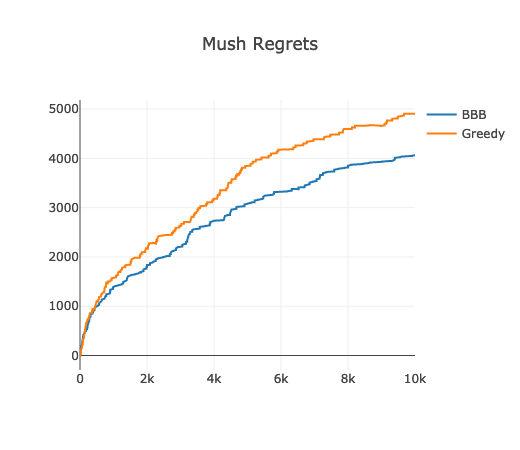

In [58]:
fig = go.FigureWidget([go.Scatter(name= net.label, y=net.cum_regrets) for net in (bbb, eps)])
fig.layout.title = 'Mush Regrets'
py.iplot(fig)

Step 1100: 
me : BBB= 2300, Greedy=1600
Yours : Greedy = 2600, BBB = 800

In [ ]:
1670 - 3560 - 1865